In [1]:
# -*- coding:utf-8 -*-
import json
import requests
import csv
import re
from lxml import etree
from datetime import date,datetime
import pandas as pd
import math
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Save_interest_rate

In [3]:
def save_interest_rate(data):
    
    # 1. 创建文件对象
    f = open('CB_interest_rate.csv', 'w', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
    csv_writer.writerow(["id","iry1", "iry2", "iry3", "iry4", "iry5", "iry6"])
    
    count = 0
    for item in data:
        count +=1
        if (count %10 == 0):
            print("processing "+str(count)+" items")
        try:
            interest = get_interest_rate(item['id'])
            interest = [item['id']]+interest
            csv_writer.writerow(interest)
        except Exception as e:
            print("Oops!", e.__class__, "occurred.")
            print("The error happed at "+item['id'])
    # 5. 关闭文件
    print("Finished processing "+str(count)+" items")
    f.close()


In [4]:
#append_interest_rate

In [5]:
def append_interest_rate(item):
    
    # 1. 创建文件对象
    interest_dict = get_interest_dict('CB_interest_rate.csv')
    if item['id'] in interest_dict:
        return
    f = open('CB_interest_rate.csv', 'a', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    
    

    try:
        interest = get_interest_rate(item['id'])
        interest = [item['id']]+interest
        csv_writer.writerow(interest)
        print("Finished appending new CB "+ item['name']+" into interest rate files")
    except Exception as e:
        print("Oops!", e.__class__, "occurred.")
        print("The error happed at "+item['id'])
    
    # 5. 关闭文件
    
    f.close()


In [6]:
#get_interest_rate

In [7]:
def get_interest_rate(id):
    years = 6
    detials_url = 'https://www.jisilu.cn/data/convert_bond_detail/'+id
    detials_response = requests.get(detials_url)
    html = detials_response.content.decode("utf-8")
    html = etree.HTML(html)
    interest = html.xpath('.//td[@id="cpn_desc"]/text()')
    pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?')  #get proper format number
    interest = pattern.findall(interest[0])
    
    if(len(interest) == 1):
        interest = interest*years
    return interest

In [8]:
# get interest dict

In [9]:
def get_interest_dict(file):
    interest_dict = dict()
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                #skip header
                line_count += 1
            else:
                interest_dict[row[0]] = row[1:]
                line_count += 1
        print(f'Processed {line_count} lines.')
    return interest_dict


In [10]:
# buy or sell cb

In [60]:
def buy_sell_db(db_df,file,show_price=False):
    total_number = len(db_df)
    quartile = np.percentile(db_df['db_low'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:db_df['name'][i] for i in db_df[0:keep_number].index}
    buy_dict = {i:db_df['name'][i] for i in db_df[0:buy_number].index}
    add_dict = {i:db_df['name'][i] for i in db_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,category = row
            if('low' in category):
                continue
            holding_dict[cb_id] = cb_name
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low}
            my_list.append(item)
            if cb_id not in keep_dict.keys():
                sell = "Sell"
                if(db_low>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f"%(sell,cb_id,cb_name,price,db_low))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = db_df.loc[cb_id]['price']
        db_low = db_df.loc[cb_id]['db_low']
        if(show_price):
            print("Add  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id in buy_dict.keys():
        if cb_id not in holding_dict.keys():
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            cb_name = keep_dict[cb_id]
            if(show_price):
                print("Buy  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('db_low',ascending=True)
    return my_df,buy_dict
    

In [12]:
#buy sell low

In [68]:
def buy_sell_low(db_df,db_buy_dict,file,show_price=False):
    total_number = len(db_df)
    quartile = np.percentile(db_df['premium'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:db_df['name'][i] for i in db_df[0:keep_number].index}
    buy_dict = {i:db_df['name'][i] for i in db_df[0:buy_number].index}
    add_dict = {i:db_df['name'][i] for i in db_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,category = row
            if cb_id not in db_df.index:
                print("Strong sell %s %s for not in the low premium list"%(cb_id,cb_name))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = db_df.loc[cb_id]['price']
            premium = db_df.loc[cb_id]['premium']
            fit_price = db_df.loc[cb_id]['fit_price']
            low_fit_price = db_df.loc[cb_id]['low_fit_price']
            upper_fit_price = db_df.loc[cb_id]['upper_fit_price']
            item = {'id':cb_id,'name':cb_name,'price':price,'premium':premium}
            my_list.append(item)
            if cb_id not in keep_dict.keys() or price>fit_price:
                if('db' in category and price<fit_price):
                    continue
                sell = "Sell"
                if(premium>quartile or price>upper_fit_price):
                    if('db' in category and price<upper_fit_price):
                        continue
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f"%(sell,cb_id,cb_name,price,premium))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = db_df.loc[cb_id]['price']
        premium = db_df.loc[cb_id]['premium']
        low_fit_price = db_df.loc[cb_id]['low_fit_price']
        if price>=low_fit_price:
            continue
        if(show_price):
            print("Add  %s %s %s %.3f"%(cb_id,cb_name,price,premium))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = db_df.loc[cb_id]['price']
        premium = db_df.loc[cb_id]['premium']
        low_fit_price = db_df.loc[cb_id]['low_fit_price']
        if cb_id in db_buy_dict.keys():
            print("Strong Buy %s %s %s %.3f"%(cb_id,cb_name,price,premium))
        if cb_id not in holding_dict.keys():
            if price>=low_fit_price:
                continue
            
            if(show_price):
                print("Buy  %s %s %s %.3f"%(cb_id,cb_name,price,premium))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    #my_df = pd.DataFrame(my_list)
    #my_df = my_df.set_index(['id'])
    #my_df = my_df.sort_values('premium',ascending=True)
    #return my_df
    

In [14]:
# read historical data

In [15]:
def read_historical_data(file):
    history_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            history_list.append(row)
    return history_list

In [16]:
# get data

In [17]:
def get_dat(get_force_redeem="No"):
    # Fill in your details here to be posted to the login form.
    payload = {
        'user_name': 'a39856ed4377d1b92cffb0677febf5b8',
        'password': 'ca5572b5ffe8c33746727709bc7d6c6f'
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
        #"User-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.106 Safari/537.36 OPR/38.0.2220.41",
        "Cookie": "kbzw__Session=l313fggdcjpnd7eineqilm6lf4; kbz_newcookie=1; kbzw_r_uname=ijayden; Hm_lvt_164fe01b1433a19b507595a43bf58262=1627073048,1627079966,1627115858,1627117055; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1627118717"
    }
    loginUrl="https://www.jisilu.cn/account/ajax/login_process/"
    r = requests.post(loginUrl,data=payload)

    newUrl ="https://www.jisilu.cn/data/cbnew/cb_list/?___jsl=LST___t=1584777951900"
    #最简单的爬虫请求.也可以加上headers字段，防止部分网址的反爬虫机制
    response = requests.get(newUrl,cookies=r.cookies)
    data = response.content.decode("utf-8")
    dat = json.loads(data)

    # 所有数据
    lst_data = []
    count = 0
    for one in dat['rows']:
        # 每一条数据
        lst_dat = dict()
        # 转债id
        id = one["id"]
        dat_cell = one["cell"]
        # 是否赎回
        is_force_redeem = dat_cell['force_redeem']
        is_list = dat_cell['price_tips']
        
            
        
        force_redeem_boolean = False
        if(get_force_redeem=="No"):
            if(is_force_redeem == None or '不行使' in is_force_redeem ):
                force_redeem_boolean = True
            else:
                force_redeem_boolean = False
        else:
            if(is_force_redeem == None):
                force_redeem_boolean = False
            else:
                force_redeem_boolean = True
        
        if force_redeem_boolean and is_list != "待上市":
            
            count += 1
            if (count %100 == 0):
                print("processing "+str(count)+" items")
            
            # 转债名称
            name = dat_cell['bond_nm']
            # 现价
            price = dat_cell['price']
            # stock id
            stock_id = dat_cell['stock_id']
            stock_id = stock_id.replace("sh", "ss")
            stock_id = stock_id[2:]+"."+stock_id[0:2]
            # stock name
            stock_nm = dat_cell['stock_nm']
            # 溢价率
            premium_rt = dat_cell['premium_rt']
            # 评级
            rating_cd = dat_cell['rating_cd']
            
            
            # next put date
            next_put_dt = dat_cell['next_put_dt']
            # put price
            put_price   = dat_cell['put_price']
            # 回售触发价
            put_convert_price = dat_cell['put_convert_price']
            
            
            # maturity date
            maturity_dt = dat_cell['maturity_dt']
            # redeem price
            redeem_price = dat_cell['redeem_price']
            
            # 强赎触发价
            redeem_dt = dat_cell['redeem_dt']
            force_redeem_price = dat_cell['force_redeem_price']
            # 剩余时间
            last_time = dat_cell['year_left']
            pb = dat_cell['pb']


            #lst_dat.append(id)
            lst_dat['id'] = id
            lst_dat['name'] = name
            lst_dat['stock_id'] = stock_id
            lst_dat['stock_name'] = stock_nm
            lst_dat['price'] = float(price)
            lst_dat['convert_value'] = float(dat_cell['convert_value'])
            lst_dat['premium_rt'] = premium_rt
            lst_dat['rating_cd'] = rating_cd
            lst_dat['pb']  = pb
            lst_dat['convert_amt_ratio'] = dat_cell['convert_amt_ratio']
            lst_dat['convert_amt_ratio2'] = dat_cell['convert_amt_ratio2']
            
            
            
            if(get_force_redeem == "No"):
                lst_dat['next_put_dt'] = next_put_dt
                lst_dat['put_price'] = put_price
                lst_dat['put_convert_price'] = put_convert_price
            
                lst_dat['maturity_dt'] = maturity_dt
                lst_dat['redeem_price'] = redeem_price
                lst_dat['last_time'] = last_time
                lst_dat['force_redeem'] = is_force_redeem
            
            else:
                lst_dat['redeem_dt']  = redeem_dt
                lst_dat['force_redeem_price'] = force_redeem_price
                lst_dat['force_redeem'] = is_force_redeem
            
  
            lst_data.append(lst_dat)
            
        else:
            continue
    print("Finished processing "+str(count)+" items")
    
    return lst_data

In [18]:
#put arbitrage

In [19]:
def put_arbitrage(data):
    data_copy = deepcopy(data)
    put_data = []
    count = 0
    for item in data_copy:
        price       = item['price']
        put_price   = item['put_price']

        
        if(put_price is None):
            continue
            
        price = float(price)
        put_price = float(put_price)
            
        if(price>put_price+5.0): ###To Save Time, the maximun interest could not over 10
            continue
            

        
        next_put_dt = item['next_put_dt']
        next_put_dt = datetime.strptime(next_put_dt,'%Y-%m-%d').date()
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        days_to_put  = next_put_dt-today
        years_to_put  = days_to_put.days/365
        
        put_to_maturity = round(years_to_maturity-years_to_put)
        #print(put_to_maturity)
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
        
        
        total_interest = 0
        for i in range(3,math.ceil(years_to_put)+put_to_maturity+1):
            #print(i)
            #print(interest)
            #print(item['id'])
            total_interest += float(interest[-i])
        
        
    
        
        actual_put_price = put_price*(1+total_interest*0.008)
        
        
        if(price<actual_put_price):
            year_diff = years_to_put + 38/365
            profit_rate = actual_put_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['actual_put_price'] = actual_put_price
            item['CAGR'] = CAGR
            item['last_to_put'] = year_diff
            put_data.append(item)
        
        count += 1
        if (count %100 == 0):
            print("processing"+str(count)+" items")
    
    print("Finished processing "+str(count)+" items")
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [20]:
# redeem arbitrage

In [21]:
def redeem_arbitrage(data):
    put_data = []
    data_copy = deepcopy(data)
    for item in data_copy:
        price       = item['price']
        redeem_price   = item['redeem_price']

        
        if(redeem_price is None):
            continue
            
        price = float(price)
        redeem_price = float(redeem_price)
            

        
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
            
        total_interest = 0
        for i in range(2,math.ceil(years_to_maturity)):
            total_interest += float(interest[-i])
            
        actual_price = redeem_price*(1+total_interest*0.008)
        
        if(price<actual_price):
            year_diff = years_to_maturity
            profit_rate = actual_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['CAGR'] = CAGR
            put_data.append(item)
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [22]:
# double low arbitarge

In [23]:
def double_low_arbitrage(data,redeem_df,put_df):
    db_data = []
    DISCOUNT = 1  ###convert amt ratio discount 
    data_copy = deepcopy(data)
    
    redeem_dict = redeem_df.to_dict('index')
    put_dict = put_df.to_dict('index')
    
    stock_amt_ratio_dict = dict()
    for item in data_copy:
        id = item['id']
        stock_id = item['stock_id']
        convert_amt_ratio = item['convert_amt_ratio']
        convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        if stock_id not in stock_amt_ratio_dict.keys():
            stock_amt_ratio_dict[stock_id] = convert_amt_ratio
        else:
            stock_amt_ratio_dict[stock_id] += convert_amt_ratio
        
    
    for item in data_copy:
        id = item['id']
        stock_id = item['stock_id']
        price       = item['price']
        premium_rt = item['premium_rt']
        #convert_amt_ratio = item['convert_amt_ratio']
        convert_amt_ratio = stock_amt_ratio_dict[stock_id]
        convert_value = item['convert_value']
        
            
        price = float(price)
        premium_rt = float(premium_rt.strip('%'))/100
        #convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        convert_value = float(convert_value)
        convert_value_discount = 1/(1+convert_amt_ratio*DISCOUNT)
        new_convert_value = convert_value*convert_value_discount
        new_premium = price/new_convert_value - 1
        #new_premium = new_premium*math.sqrt(price/100) if price>100 else new_premium
        
        redeem_cagr = 0
        put_cagr = 0
        if(id in redeem_dict.keys()):
            redeem_cagr = redeem_dict[id]['CAGR']
        if(id in put_dict.keys()):
            put_cagr = put_dict[id]['CAGR']
        
        item['redeem_CAGR'] = redeem_cagr
        item['put_CAGR']    = put_cagr
        item['new_convert_value'] = new_convert_value
        item['new_premium'] = new_premium
        if(redeem_cagr>put_cagr):
            db_low = price + new_premium*100 - redeem_cagr*100
        else:
            db_low = price + new_premium*100 - put_cagr*100
        
        #item['db_low'] = db_low*math.sqrt(price/100) if price>100 else db_low
        item['db_low'] = db_low
        
        db_data.append(item)
    df = pd.DataFrame(db_data)
    df = df.set_index(['id'])
    df = df.sort_values('db_low')
    return df

In [24]:
# low premium arbitrage

In [92]:
def low_premium_arbitrage(db_df): 
    import scipy.stats as stats
    x = []
    y = []
    ids = []
    names = []
    for cb_id in db_df.index:
        name = db_df['name'][cb_id]
        value = db_df['new_convert_value'][cb_id]
        price = db_df['price'][cb_id]
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        x.append(value)
        y.append(price)
        ids.append(cb_id)
        names.append(name)

    x = np.array(x)
    y = np.array(y)
    ids = np.array(ids)
    names = np.array(names)
    indexes = np.argsort(x)
    x = x[indexes]
    y = y[indexes]
    ids = ids[indexes]
    names = names[indexes]

    coef = np.polyfit(x, y, 2)
    save_coef_data(coef,'coef_history.csv')
    poly = np.poly1d(coef)

    n = len(x)
    yfit = poly(x)
    resid = y - yfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)
    # Confidence interval for the linear fit:
    t = stats.t.ppf(0.8, n - 2)
    ci = t * s_err * np.sqrt(1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = t * s_err * np.sqrt(1 + 1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))

    convert_value_limit = (1-coef[1])/2/coef[0]
    price_limit = poly(convert_value_limit)
    xext = np.linspace(convert_value_limit,max(x))
    yext = xext+price_limit-convert_value_limit

    lp_data = []
    for i,cb_id in enumerate(ids):
        value = x[i]
        price = y[i]
        cb_name = names[i]
        

        premium = (price/value-1)*100
        item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                'fit_price':yfit[i],'low_fit_price':yfit[i]-pi[i],'upper_fit_price':yfit[i]+pi[i]}
        if(price<price_limit):
            lp_data.append(item)
        if cb_id in my_df.index:
        #if price<yfit[i]-pi[i]:
            plt.scatter(value, price, marker='o', s=5,color='maroon')
            plt.text(value+.03, price+.03, cb_id, fontsize=5)
        else:
            plt.scatter(value, price, marker='o', s=5,color='darkgreen')
            



    lp_df = pd.DataFrame(lp_data)
    lp_df = lp_df.set_index(['id'])
    lp_df = lp_df.sort_values('premium')
    plt.plot(x,yfit,color='red')
    plt.plot(xext,yext,color='skyblue')
    plt.fill_between(x, yfit-ci, yfit+ci,color=[1, 0, 0, 0.15])
    plt.fill_between(x, yfit-pi, yfit+pi,color=[1, 0, 0, 0.1])
    #plt.plot(x,yfit)
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    plt.show()
    return lp_df

In [26]:
# save historical data

In [87]:
def save_historical_data(df,col,file):
    s = df[col]
    min_db = s.min()
    max_db = s.max()
    mean_db = s.mean()
    median_db = s.median()
    pt2_db = np.percentile(s,2)
    pt5_db = np.percentile(s,5)
    pt10_db = np.percentile(s,10)
    quartile_db = np.percentile(s,25)
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        #csv_writer.writerow(["date","min", "quartile", "median", "mean", "max"])
        today_item = [today,str(min_db),str(pt2_db),str(pt5_db),str(pt10_db),str(quartile_db),str(median_db),str(mean_db),str(max_db)]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","min", "pt2","pt5","pt10","quartile", "median", "mean", "max"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,min_db,pt2_db,pt5_db,pt10_db,quartile_db,median_db,mean_db,max_db])
        f.close()
    
    print('today quartile '+str(quartile_db))
    
    

In [ ]:
#save coeffient 

In [91]:
def save_coef_data(coef,file):
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        today_item = [today,str(coef[0]),str(coef[1]),str(coef[2])]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","a", "b","c"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,coef[0],coef[1],coef[2]])
        f.close()
    
    print('today coef '+str(coef))
    

In [28]:
# plot history

In [29]:
def plot_history(file):
    his = pd.read_csv(file, sep=',')
    plt.plot( 'date', 'min', data=his, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
    plt.plot( 'date', 'pt2', data=his, marker='o', markerfacecolor='sienna', markersize=6, color='peru', linewidth=2)
    plt.plot( 'date', 'pt5', data=his, marker='o', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    plt.plot( 'date', 'pt10', data=his, marker='o', markerfacecolor='gold', markersize=6, color='goldenrod', linewidth=2)
    plt.plot( 'date', 'quartile', data=his, marker='o', markerfacecolor='olivedrab', markersize=6, color='olive', linewidth=2)
    plt.plot( 'date', 'median', data=his, marker='o', markerfacecolor='darkorange', markersize=6, color='orange', linewidth=2)
    #plt.plot( 'date', 'mean', data=his, marker='v', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    # show legend
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    # show graph
    plt.show()

In [30]:
data = get_dat()
pd.DataFrame.from_dict(data).to_csv(r'CB_list.csv',index=False)
#force_redeem_data = get_dat('Yes')
#pd.DataFrame.from_dict(force_redeem_data).to_csv(r'CB_force_redeem_list.csv',index=False)

processing 100 items
processing 200 items
processing 300 items
Finished processing 368 items


In [31]:
interest_dict = get_interest_dict('CB_interest_rate.csv')

Processed 381 lines.


In [32]:
redeem_df = redeem_arbitrage(data)

In [33]:
put_df = put_arbitrage(data)

Finished processing 70 items


today coef [2.79801917e-03 8.49982994e-02 8.99019769e+01]
mse=53.228


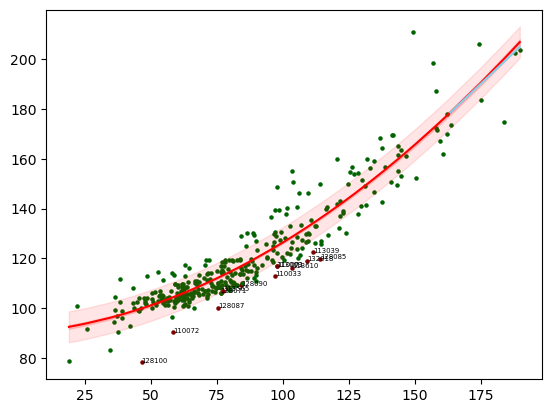

In [93]:
db_df = double_low_arbitrage(data,redeem_df,put_df)
lp_df = low_premium_arbitrage(db_df)

In [63]:
my_df,db_buy_dict = buy_sell_db(db_df,'mycb_list.csv',show_price=True)

Sell 113565 宏辉转债 106.97 143.217
Sell 128071 合兴转债 106.135 143.328

Add  128085 鸿达转债 119.74 124.081
Add  113610 灵康转债 116.06 127.620
Add  132018 G三峡EB1 118.87 127.895
Add  110033 国贸转债 112.99 129.242
Add  128087 孚日转债 100.122 130.390
Add  113039 嘉泽转债 122.41 132.239
Add  113030 东风转债 110.93 133.393

Buy  113030 东风转债 110.93 133.393
Buy  113541 荣晟转债 120.18 134.009
Buy  113607 伟20转债 130.1 135.155
Buy  110070 凌钢转债 125.67 135.564
Buy  113508 新凤转债 121.52 135.731
Buy  123106 正丹转债 113.201 137.237
Buy  128133 奇正转债 112.303 137.865
Buy  132014 18中化EB 127.0 137.881


In [69]:
buy_sell_low(lp_df,db_buy_dict,'mycb_list.csv',show_price=True)

No CB to sell

Add  123102 华自转债 174.811 -4.852
Add  128051 光华转债 162.0 0.812
Add  113585 寿仙转债 152.39 1.367
Add  113012 骆驼转债 142.76 3.833
Add  123050 聚飞转债 149.401 4.294
Add  120003 19华菱EB 167.0 4.739

Buy  123102 华自转债 174.811 -4.852
Buy  128051 光华转债 162.0 0.812
Buy  113585 寿仙转债 152.39 1.367
Buy  113012 骆驼转债 142.76 3.833
Buy  123050 聚飞转债 149.401 4.294
Buy  120003 19华菱EB 167.0 4.739
Buy  113504 艾华转债 170.05 4.944
Strong Buy 128085 鸿达转债 119.74 5.044
Strong Buy 113607 伟20转债 130.1 5.055
Buy  120004 20华菱EB 152.985 5.612
Buy  127029 中钢转债 150.6 6.819
Buy  123098 一品转债 137.82 7.417
Buy  123078 飞凯转债 141.491 7.574


In [59]:
my_df

,name,price,db_low
id,,,
128085,鸿达转债,119.740,124.080657
113610,灵康转债,116.060,127.619919
132018,G三峡EB1,118.870,127.895260
110033,国贸转债,112.990,129.241898
128087,孚日转债,100.122,130.390348
113039,嘉泽转债,122.410,132.238511
128100,搜特转债,78.220,136.139543
110071,湖盐转债,116.810,136.155144
113009,广汽转债,116.760,136.355283


today quartile 151.67834922840365


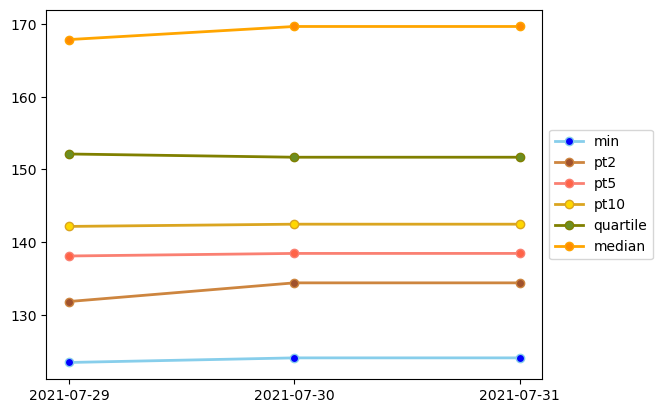

In [88]:
save_historical_data(db_df,'db_low','db_history.csv')
plot_history('db_history.csv')

today quartile 26.51749415429049


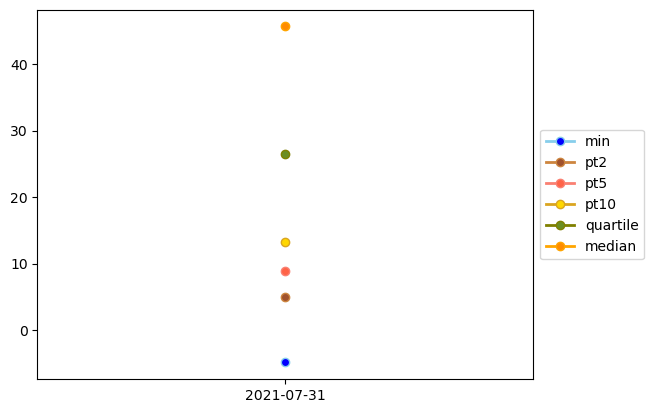

In [89]:
save_historical_data(lp_df,'premium','premium_history.csv')
plot_history('premium_history.csv')

In [38]:
db_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,put_convert_price,maturity_dt,redeem_price,last_time,force_redeem,redeem_CAGR,put_CAGR,new_convert_value,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,,
128085,鸿达转债,002002.sz,鸿达兴业,119.740,119.69,0.04%,B,1.63,5.0%,5.0%,...,2.74,2025-12-16,118.000,4.384,None,0.007032,0.000000,113.990476,0.050439,124.080657
113610,灵康转债,603669.ss,灵康药业,116.060,111.38,4.20%,AA-,4.52,7.7%,7.7%,...,6.03,2026-11-30,115.000,5.340,None,0.006655,0.000000,103.416899,0.122254,127.619919
132018,G三峡EB1,600900.ss,长江电力,118.870,113.50,4.87%,AAA,2.47,4.1%,4.1%,...,11.72,2024-04-09,108.000,2.696,None,0.000000,0.000000,109.029779,0.090253,127.895260
110033,国贸转债,600755.ss,厦门国贸,112.990,105.65,6.95%,AAA,0.54,8.7%,8.3%,...,4.70,2022-01-05,108.000,0.436,None,0.000000,0.000000,97.194112,0.162519,129.241898
128087,孚日转债,002083.sz,孚日股份,100.122,88.89,12.64%,AA-,1.00,17.9%,17.9%,...,3.15,2025-12-17,108.000,4.386,None,0.025293,0.009391,75.394402,0.327977,130.390348
113039,嘉泽转债,601619.ss,嘉泽新能,122.410,117.92,3.81%,AA,2.53,5.8%,5.6%,...,2.42,2026-08-23,108.000,5.068,None,0.000000,0.000000,111.455577,0.098285,132.238511
113030,东风转债,601515.ss,东风股份,110.930,93.18,19.05%,AA,1.72,3.7%,3.7%,...,4.51,2025-12-23,112.000,4.403,None,0.009911,0.000000,89.855352,0.234540,133.392864
113541,荣晟转债,603165.ss,荣晟环保,120.180,111.07,8.20%,AA-,1.81,5.2%,5.2%,...,7.59,2025-07-22,110.000,3.981,None,0.000000,0.000000,105.579848,0.138285,134.008541
113607,伟20转债,603568.ss,伟明环保,130.100,128.05,1.60%,AA,6.13,3.4%,3.4%,...,15.20,2026-11-01,110.000,5.260,None,0.000000,0.000000,123.839458,0.050554,135.155369


In [39]:
db_df[10:20]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,put_convert_price,maturity_dt,redeem_price,last_time,force_redeem,redeem_CAGR,put_CAGR,new_convert_value,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,,
113508,新凤转债,603225.ss,新凤鸣,121.520,122.36,-0.69%,AA,2.13,5.5%,5.3%,...,10.96,2024-04-25,108.000,2.740,None,0.000000,0.000000,106.400000,0.142105,135.730526
128100,搜特转债,002503.sz,搜于特,78.220,55.52,40.89%,A,1.43,19.5%,16.1%,...,2.03,2026-03-11,112.000,4.616,None,0.088811,0.104394,46.460251,0.683590,136.139543
110071,湖盐转债,600929.ss,雪天盐业,116.810,108.74,7.42%,AA,2.39,11.1%,10.9%,...,4.56,2026-07-09,110.000,4.945,None,0.000000,0.000000,97.875788,0.193451,136.155144
113009,广汽转债,601238.ss,广汽集团,116.760,100.07,16.68%,AAA,1.67,2.5%,1.8%,...,9.78,2022-01-22,106.000,0.482,None,0.000000,0.000000,97.629268,0.195953,136.355283
123106,正丹转债,300641.sz,正丹股份,113.201,98.00,15.51%,AA-,2.43,8.9%,8.9%,...,5.25,2027-03-23,120.000,5.649,None,0.017556,0.000000,89.990817,0.257917,137.237168
128133,奇正转债,002287.sz,奇正藏药,112.303,93.75,19.79%,AA,5.43,5.4%,5.4%,...,20.85,2026-09-21,112.000,5.148,None,0.006969,0.000000,88.946869,0.262585,137.864661
132014,18中化EB,601117.ss,中国化学,127.000,122.44,3.92%,AAA,1.11,6.9%,6.9%,...,4.99,2023-04-24,106.000,1.734,None,0.000000,0.000000,114.536950,0.108812,137.881248
128090,汽模转2,002510.sz,天汽模,109.200,91.49,19.36%,AA-,1.74,8.6%,8.5%,...,2.96,2025-12-27,110.000,4.414,None,0.009360,0.000000,84.244936,0.296220,137.886017
128057,博彦转债,002649.sz,博彦科技,119.490,111.65,7.02%,AA-,1.62,11.1%,9.8%,...,5.95,2025-03-05,112.000,3.600,None,0.000000,0.000000,100.495050,0.189014,138.391379


In [65]:
lp_df[0:20]

,name,value,price,premium,fit_price,low_fit_price,upper_fit_price
id,,,,,,,
123102,华自转债,183.725835,174.811,-4.852249,199.966008,193.703530,206.228486
128051,光华转债,160.695397,162.000,0.811849,175.814091,169.587425,182.040757
113585,寿仙转债,150.334317,152.390,1.367408,165.916510,159.702926,172.130093
113012,骆驼转债,137.490310,142.760,3.832772,154.481014,148.281012,160.681015
123050,聚飞转债,143.250240,149.401,4.293717,159.495123,153.289392,165.700854
120003,19华菱EB,159.443930,167.000,4.739014,174.586709,168.361724,180.811694
113504,艾华转债,162.038647,170.050,4.944100,177.141242,170.912742,183.369742
128085,鸿达转债,113.990476,119.740,5.043863,135.947955,129.765195,142.130715
113607,伟20转债,123.839458,130.100,5.055369,143.339134,137.150350,149.527918


In [79]:
a = 'db_low'
b = db_df[a]
b.min()
np.percentile(db_df['db_low'],5)
np.percentile(b,5)

138.4470019631681

In [57]:
lp_df[(lp_df['value'] < 30) & (lp_df['price']>70)]

,name,value,price,premium,fit_price,low_fit_price,upper_fit_price
id,,,,,,,
113596,城地转债,25.722502,91.500,255.719676,93.939647,87.733065,100.146229
128062,亚药转债,18.939808,78.623,315.120354,92.515524,86.301343,98.729704
132011,17浙报EB,22.188235,100.900,354.745493,93.165454,86.955014,99.375894


In [40]:
put_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,next_put_dt,put_price,put_convert_price,maturity_dt,redeem_price,last_time,force_redeem,actual_put_price,CAGR,last_to_put
id,,,,,,,,,,,,,,,,,,,,
128062,亚药转债,002370.sz,亚太药业,78.623,27.69,183.94%,BB,3.79,46.2%,39.9%,2023-04-03,100.000,11.38,2025-04-02,115.000,3.677,None,102.00,0.157397,1.780822
128100,搜特转债,002503.sz,搜于特,78.220,55.52,40.89%,A,1.43,19.5%,16.1%,2024-03-11,100.000,2.03,2026-03-11,112.000,4.616,None,102.48,0.104394,2.720548
113595,花王转债,603007.ss,ST花王,83.400,45.38,83.78%,A,0.91,31.5%,31.3%,2024-07-22,100.000,4.84,2026-07-20,116.000,4.975,None,102.64,0.069604,3.084932
128044,岭南转债,002717.sz,岭南股份,96.163,47.21,103.69%,AA-,0.95,21.0%,15.5%,2022-08-14,100.000,4.14,2024-08-14,107.000,3.044,None,102.00,0.052803,1.145205
113576,起步转债,603557.ss,ST起步,90.440,42.18,114.41%,A,1.36,12.1%,12.1%,2024-04-09,100.000,7.38,2026-04-09,115.000,4.696,2020年11月6日公告，本次（2020年10月16日至2020年11月5日）不行使起步转债...,103.04,0.047684,2.800000
113017,吉视转债,601929.ss,吉视传媒,98.850,58.64,68.57%,AA+,0.77,29.0%,29.0%,2021-12-27,100.000,2.06,2023-12-27,106.000,2.411,None,101.04,0.043462,0.515068
110072,广汇转债,600297.ss,广汇汽车,90.260,67.49,33.74%,AA+,0.54,15.3%,15.3%,2024-08-19,100.000,2.82,2026-08-17,110.000,5.052,None,102.16,0.039949,3.161644
113596,城地转债,603887.ss,城地香江,91.500,35.78,155.73%,AA-,0.95,39.1%,30.7%,2024-07-29,100.000,16.98,2026-07-27,108.000,4.995,None,102.48,0.037184,3.104110
127019,国城转债,000688.sz,国城矿业,93.000,45.54,104.22%,AA,4.42,7.8%,7.8%,2024-07-15,100.000,14.74,2026-07-14,110.000,4.959,None,102.40,0.031906,3.065753
